In [2]:
library(tidyverse)
library(latex2exp)

*Based on "A simple introduction to Markov Chain Monte–Carlo sampling" by [Ravenzwaaij et al.](https://link.springer.com/content/pdf/10.3758%2Fs13423-016-1015-8.pdf), and blog post by [Pablo R. Mier](https://pablormier.github.io/2017/09/05/a-tutorial-on-differential-evolution-with-python/)*

### Introduction

In two previous blog posts, we covered the basics of MCMC and 2 common implementations - [Metropolis-Hastings Algorithm](/2020/03/01/markov-chain-monte-carlo-mcmc-metropolis-hastings/) <sup id="a1">[1](#f1)</sup>, and [Gibbs Sampling](/2020/03/03/markov-chain-monte-carlo-mcmc-gibbs-sampling/). In this post, I will discuss the last algorithm discussed in the Ravenzwaaij paper cited above - Differential Evolution (DE).

### Motivation for DE?

As discussed [previously](/2020/03/03/markov-chain-monte-carlo-mcmc-gibbs-sampling/), the sampling procedure used by the Metropolis/Gibbs sampling algorithms may sometimes be a hindrance to fast convergence (e.g. parameters may be drawn from distributions that are heavily correlated, or parameter sets may have many dimensions).

Gibbs sampling tries to resolve this to some extent by drawing from conditional probabilities, but it doesn't fully resolve the issue of correlation in the accept-reject phase. This is illustrated below:

In [ ]:
set.seed(1)
n = 10000
x = rnorm(n)
y = 2*x + 3 + rnorm(n, 0, 1.25)
test = data.frame(x = x, y = y)
ggplot(test, aes(x = x, y = y)) +
  geom_point(fill = 'light grey', pch = 21, size = 2, colour = 'light grey') + 
  geom_point(data = data.frame(x = -1.5, y = 3),
             pch=21, fill=NA, size=25, colour="red", stroke=1.5) + 
  geom_point(data = data.frame(x = -1.5, y = 3),
             pch=21, fill='black', size=2, colour="black", stroke=0.5) +
  geom_point(data = data.frame(x = -1.7, y = 4.2),
             pch=21, fill='blue', size=2, colour="blue", stroke=0.5) +
  annotate('text', x = -1.05, y = 2, label = TeX("$(x_0,y_0)$")) +
  annotate('text', x = -2.05, y = 5.2, label = TeX("$(x_1,y_1)$"), colour = 'blue') +
  theme_classic()

The chart above shows a scatter plot of 2 parameters. Suppose we start off at the orange point as our prior value. The Metropolis/Gibbs algorithm effectively samples the space around the chosen point uniformly to arrive at the next proposal. As you might imagine, this leads to more rejections than necessary since a large proportion of the proposals will not take the parameter correlation into account.

### Differential Evolution (DE)

DE is a class of algorithms that are proposed to solve optimisation problems that may not have a clear functional form, such that the usual methods of taking the partial derivatives does not always work. The main insight of DE algorithms is that global minima can be reached simply by using vector differences to perturb the vector population. Intuitively, this resolves correlational issues since vector differences between "accepted" values will tend to be oriented along the axis in the direction towards the minima, and this approach doesn't rely on any parametric assumptions.

This sounds unnecessarily complicated, but it really isn't. We will explore a simulation in the next section to illustrate this process. 

Briefly, the DE algorithm is: <br>

1. Choose $N$ guesses to serve as the starting parameter(s) guess of for each of your simulated sampling chains. Let's call these chains $\Theta_1, \Theta_2, ..., \Theta_N$ where $\Theta_i = (\theta_{i,1}, \theta_{i,2}...)$. Note that $Theta_i$ is a general representation; it can be a vector of parameters or a single parameter.
2. For each of these starting values, we calculate a "fitness" score relative to our cost function. To use the same example used in the previous posts, we are evaluating the likelihood of the parameters relative to the test scores we see.
3. Let's suppose we want to generate the next parameter values for the $\Theta_1$ chain. Call this the **target vector**.
4. We choose 3 other chains at random, and call these $\Theta_{i}$, $\Theta_{j}$ and $\Theta_{k}$.
5. We designate the $\Theta_{i}$ as our **base vector**, and find the vector difference between $\Theta_{j}$ and $Theta_{k}$. More specifically, for each element $\theta_{i,x}$ in $\Theta_{i} = (\theta_{i,x}); x \in 1:n$, we add the difference $\theta_{j,x} - \theta_{k,x}$ multiplied by a hyperparameter $\gamma$. To avoid cases where the values are the same, we add a random perturbation $\epsilon_x$.
6. By doing this, we generate a new vector $\Theta_{i'}$. Let's call this the **mutant vector**. This is the "mutation" phase of the algorithm, similar to the proposal step in our earlier algorithms. Notice how the proposed changes are in are aligned along the same axis as the vector differences between accepted values in other chains!
7. We now randomly choose to swap values between our mutant and target vectors, thereby mixing new pieces of information with our existing target vector. This is the final transformation to be performed, and we call this the **trial vector**.
8. Compare the performance of the trial vector to the target vector. If the trial vector outperforms the target, it now replaces the target as one of our $N$ proposed vectors. Otherwise reject it. Simulated annealing is *extremely* suboptimal here. You are using other vectors as part of your proposal criteria, so accepting suboptimal parameters will cause non-convergence.

### Visualising the DE Accept-Reject Process

In our earlier algorithms, we could visualise the accept-reject process since only 1 chain is considered at any time. Under DE, however, there are multiple chains of simulations, and hence multiple values. To avoid confusion, I will just visualise 1 chain out of the multiple simulations. But keep in mind that the evolution of the values across all chains are essentially similar; that is, they all converge to the minima.

Let's first recap how the convergence path looked like under the Metropolis algorithm and Gibbs sampling:


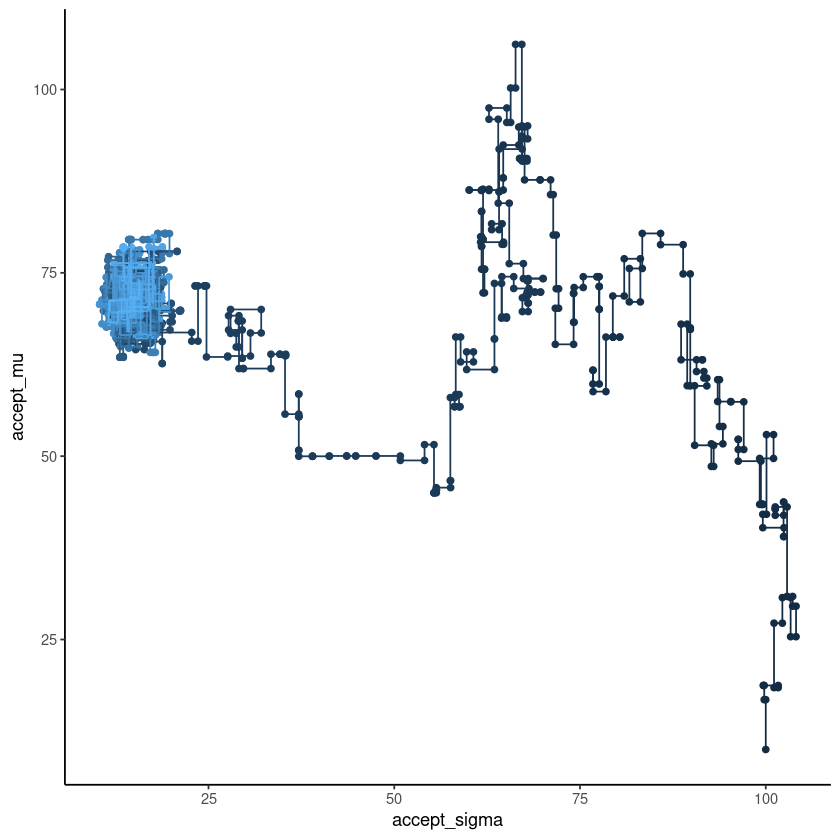

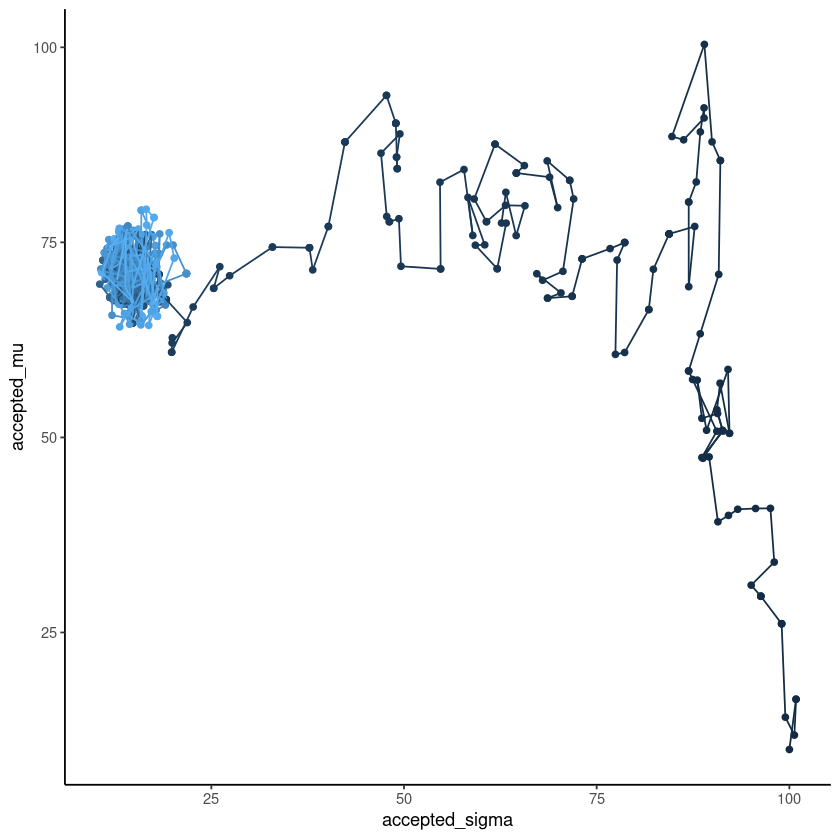

In [3]:
# Gibbs Sampler code
gibbs_sampling <- function(data, proposed_mu, proposed_sigma, niter = 500){
  
  proposed_param = data.frame(proposed_mu = proposed_mu, proposed_sigma = proposed_sigma)
  accept_param = data.frame(accept_mu = proposed_mu, accept_sigma = proposed_sigma)
  
  current_mu = proposed_mu
  current_sigma = proposed_sigma
  
  for(i in 1:niter){
    
    # Proposal for mu ====
    proposal_draw = rnorm(1, 0, 5)
    
    # Compare the earlier proposal value for mu with the new. 
    candidate1 = sum(log(dnorm(data, current_mu, current_sigma)))
    candidate2 = sum(log(dnorm(data, current_mu + proposal_draw, current_sigma)))
    proposed_param = proposed_param %>%
      bind_rows(data.frame(proposed_mu = current_mu + proposal_draw, proposed_sigma = current_sigma))
    
    # If new proposed value gives you a higher chance of observing first_value, accept it. Otherwise, accept new proposal with probability proportionate to how much lower the posterior is compared to the original proposal. This prevents getting stuck in local maxima.
    if(candidate2 > candidate1){
      current_mu = current_mu + proposal_draw
    } else {
      if(runif(1, 0, 1) <= (exp(candidate2 - candidate1))){
        current_mu = current_mu + proposal_draw
      }
    }
    accept_param = accept_param %>%
      bind_rows(data.frame(accept_mu = current_mu, accept_sigma = current_sigma))
    
    # Proposal for sigma ====
    
    proposal_draw = rnorm(1, 0, 2)
    
    # Compare the earlier proposal value for mu with the new. 
    candidate1 = sum(log(dnorm(data, current_mu, current_sigma)))
    candidate2 = sum(log(dnorm(data, current_mu, current_sigma + proposal_draw)))
    proposed_param = proposed_param %>%
      bind_rows(data.frame(proposed_mu = current_mu, proposed_sigma = current_sigma + proposal_draw))
    # If new proposed value gives you a higher chance of observing first_value, accept it. Otherwise, accept new proposal with probability proportionate to how much lower the posterior is compared to the original proposal. This prevents getting stuck in local maxima.
    if(candidate2 > candidate1){
      current_sigma = current_sigma + proposal_draw
    } else {
      if(runif(1, 0, 1) <= (exp(candidate2 - candidate1))){
        current_sigma = current_sigma + proposal_draw
      }
    }
    accept_param = accept_param %>%
      bind_rows(data.frame(accept_mu = current_mu, accept_sigma = current_sigma))
    
  }
  return(proposed_param %>% bind_cols(accept_param))
}

# Metropolis Sampler code
metropolis_algo_multiDim <- function(data, proposed_mu, proposed_sigma, niter = 500){
  mu_vector = c(proposed_mu)
  new_mu = c(proposed_mu)
  
  sigma_vector = c(proposed_sigma)
  new_sigma = c(proposed_sigma)
  
  for(i in 1:niter){ #do x runs
    proposal_draw_mu = rnorm(1, 0, 5)# We define an arbitrary proposal mechanism; in this case, you draw from a normal distribution with mean 0 and sd 5
    proposal_draw_sigma = rnorm(1, 0, 2)
    
    # Compare the earlier proposal value for mu with the new. 
    candidate1 = sum(log(dnorm(data, proposed_mu, proposed_sigma)))
    candidate2 = sum(log(dnorm(data, proposed_mu + proposal_draw_mu, proposed_sigma + proposal_draw_sigma)))
    
    new_mu = c(new_mu, proposed_mu + proposal_draw_mu)
    new_sigma = c(new_sigma, proposed_sigma + proposal_draw_sigma)
    
    # If new proposed value gives you a higher chance of observing first_value, accept it. Otherwise, accept new proposal with probability proportionate to how much lower the posterior is compared to the original proposal. This prevents getting stuck in local maxima.
    if(candidate2 > candidate1){
      proposed_mu = proposed_mu + proposal_draw_mu
      proposed_sigma = proposed_sigma + proposal_draw_sigma
    } else {
      if(runif(1, 0, 1) <= (exp(candidate2 - candidate1))){
        proposed_mu = proposed_mu + proposal_draw_mu
        proposed_sigma = proposed_sigma + proposal_draw_sigma
      }
    }
    
    # Store each winning proposal to a vector
    mu_vector = c(mu_vector, proposed_mu)
    sigma_vector = c(sigma_vector, proposed_sigma)
  }
  return(data.frame(mu_vector) %>% cbind(new_mu) %>% cbind(sigma_vector) %>% cbind(new_sigma) %>% `colnames<-`(c('accepted_mu', 'proposed_mu', 'accepted_sigma', 'proposed_sigma')))
}

# Generate student results
set.seed(1)
student_results <- rnorm(n = 30, mean = 70, sd = 15)
student_results[student_results > 100] = 100

gibbs_sampling(student_results, proposed_mu = 10, proposed_sigma = 100, niter = 1000) %>%
  mutate(series = 1:2001) %>%
  ggplot(aes(x = accept_sigma, y = accept_mu, colour = series)) +
  geom_point() +
  geom_path() +
  theme_classic() +
  theme(legend.position = 'none')

metropolis_algo_multiDim(student_results, proposed_mu = 10, proposed_sigma = 100, niter = 1000) %>%
  mutate(series = 1:1001) %>%
  ggplot(aes(x = accepted_sigma, y = accepted_mu, colour = series)) +
  geom_point() +
  geom_path() +
  theme_classic() +
  theme(legend.position = 'none')

What does the DE path look like?

[1] "Converged mu: 70.7410219461151"
[1] "Converged sigma: 15.2976789961081"


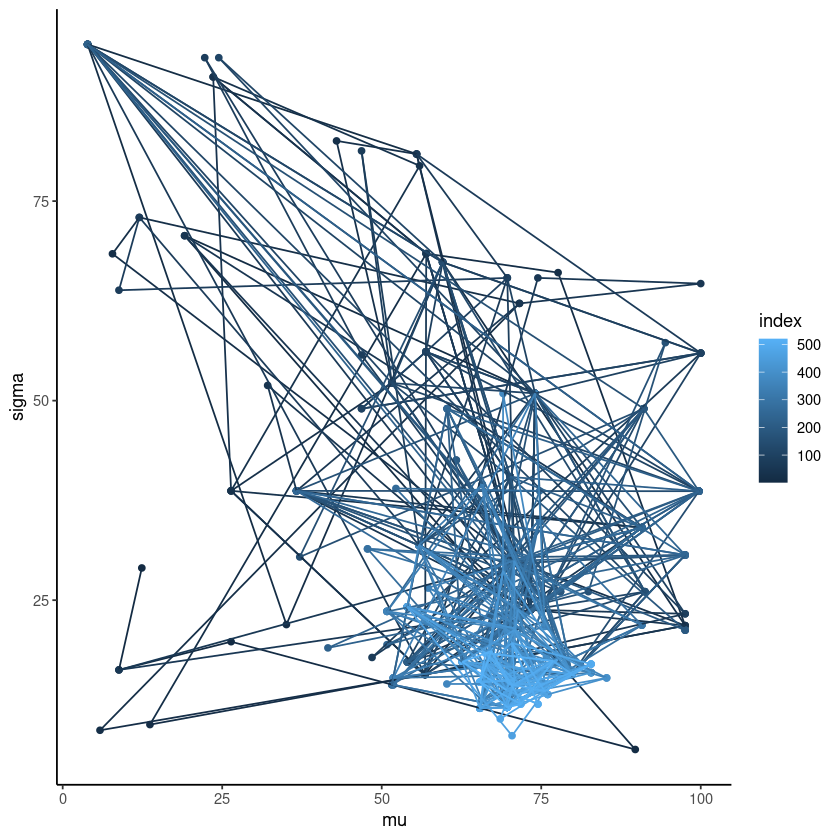

In [5]:
# Differential Evolution code
calculate_fitness = function(data = student_results, mu, sigma){sum(log(dnorm(data, mu, sigma)))}
differential_evolution <- function(data, nchains, nparams, niter = 5000, gamma = 1.19, swap_prob = 0.25){
  
  # nchains = 10
  # nparams = 2
  # niter = 5000
  # gamma = 1.19
  # swap_prob = 0.25
  
  proposed_starts <- as.data.frame(matrix(lapply(1:(nchains*nparams), function(x) runif(1)*100), ncol = 2)) %>% `colnames<-`(c('mu', 'sigma'))
  proposed_starts <- apply(proposed_starts, 2, function(x) unlist(x))
  population = proposed_starts
  record = cbind(unlist(population), swapIndex = 1:nchains)
  
  for(i in 1:niter){
    random_chain_choices <- sample(1:nchains, size = 4, replace = F)
  
    target_vector = population[random_chain_choices[1],]
    base_vector = population[random_chain_choices[2],]
    diff_vector_1 = population[random_chain_choices[3],]
    diff_vector_2 = population[random_chain_choices[4],]
    
    proposal_value = gamma * (diff_vector_2 - diff_vector_1) + runif(1, -0.001, 0.001)
    mutant_vector = (base_vector) + (proposal_value)
    swap_here = runif(2) <= swap_prob
    mutant_vector[swap_here] = target_vector[swap_here]
    trial_vector <- mutant_vector
    trial_vector[trial_vector < 0] = 0
    trial_vector[trial_vector > 100] = 100
    
    trial_fitness = calculate_fitness(mu = trial_vector[1], sigma = trial_vector[2])
    if(trial_fitness == -Inf){
      trial_fitness = -999999
    } else if(trial_fitness == Inf){
      trial_fitness = 999999
    }
    target_fitness = calculate_fitness(mu = target_vector[1], sigma = target_vector[2])
    if(target_fitness == -Inf){
      target_fitness = -999999
    } else if(target_fitness == Inf){
      target_fitness = 999999
    }
    
    if(trial_fitness > target_fitness){
      population[random_chain_choices[1],] <- trial_vector
      record <- rbind(record, c(unlist(trial_vector), swapIndex = random_chain_choices[1]))
    } else {
      record <- rbind(record, c(unlist(target_vector), swapIndex = random_chain_choices[1]))
    }
  }
  return(list(population, record))
}

de_data <- differential_evolution(data = student_results, nchains = 20, nparams = 2, niter = 500)
print(paste0('Converged mu: ', mean(de_data[[1]][,'mu'])))
print(paste0('Converged sigma: ', mean(de_data[[1]][,'sigma'])))

de_data[[2]] %>%
  as.data.frame() %>%
  mutate(index = 1:nrow(.)) %>%
  # filter(swapIndex == 2) %>%
  ggplot(aes(x = mu, y = sigma, colour = index)) +
  geom_point() +
  geom_path() +
  theme_classic()

### Conclusion

The results shown above may be a tad underwhelming, so it's important to contextualise this a little. Clearly, there isn't too much difference between the 3 algorithms for this 2 dimensional problem. As dimensionality increases, however, convergence is **exponentially** harder. A 2 dimensional problem with binary inputs only has $2^2 = 4$ solution, but a 10 dimensional problem with binary inputs has $2^{10} = 1024$ solutions.

Overall, the main idea behind DE that vector differences help to orient the direction of your updates is a powerful one, and the DE literature has evolved over the years since its introduction in 1996. In fact, it has even been used extensively in neural network convergence as an alternative to gradient descent.


<b id="f1">1</b> Start here if you're new to this! [↩](#a1)